# A simple MACD - Moving Average Convergence Divergence Buy and Sell Strategy

## 0. Objectives

In this notebook, we will be using real stock data from GAFAM (google, apple, meta, amazon and microsoft), but it works with any available ticker) and implement MACD indicators to understand their mecanism and how they can be useful for algorithmic trading.


For simplicity here, we decided to use stock closing prices, however as always, these analysis can be done using opening prices or intra-day trading data as well, provided one has access to them.


This Jupyter Notebook presents a comprehensive analysis of investment strategies using the performance metrics of GAFAM stocks - Google, Apple, Facebook(now Meta), Amazon, and Microsoft. The project evaluates two distinct approaches: an active strategy utilizing **Moving Average Convergence Divergence (MACD) for trading signals**, and a **passive strategy employing dollar-cost averaging (DCA) with the SPDR S&P 500 ETF Trust (SPY) as a benchmark**.

We will be double-checking our implementation of MACD with Ta-Lib, a widely used open-source trading software to perform technical analysis of financial market data. (Reference : https://machinelearning-basics.com/)

The analysis spans a two-year period, with an initial investment capital of $\$100,000$, focusing on the daily allocation of $500 to understand the effectiveness of dollar-cost averaging in mitigating market volatility. The inclusion of transaction costs provides a realistic touch to the simulation, highlighting the impact of trading expenses on investment returns.


We utilize a various performance metrics such as **total and annualized returns, maximum drawdown, Sharpe Ratio, Sortino Ratio, beta, and alpha** to offer a multifaceted view of the strategies' outcomes. The evolution of portfolio values is visualized through Matplotlib graphs, illustrating the trajectories of individual GAFAM stocks and the cumulative portfolio value over time.

The findings offer insightful revelations about the benefits and limitations of active versus passive investment strategies in the context of a highly volatile market, highlighted by the tech sector's performance (here Big Tech Giants in particular). 

This notebook serves as both a strategic introduction guide and an education template for financial analysis in making informed decisions backed by quantitative data.

**Caveat : Please note that I am not a financial advisor, and this analysis should not be taken as financial advice. The study may presents potential biases inherent in historical data analysis, model assumptions or implementations errors, and readers are advised to conduct further research and seek professional advice before making investment decisions.**

## 1. Definitions

**Moving Average Convergence Divergence (MACD)** is a **momentum** and **trend-following** technical indicator (or oscillator). It’s composed of 3 times series:
1. **MACD line** which is calculated by subtracting the 26-day exponential moving average (Slow EMA) from the 12-day EMA (Fast EMA) of an asset’s price (often close).
2. **MACD Signal** line which is calculated as the 9-day exponential moving average (EMA) of the MACD line.
3. **MACD Histogram** (Also called divergence), which is the difference between the MACD line and its Signal line.

**Formulas**
- $MACD_{Line} = 12_{day} EMA - 26_{day} EMA$

  Where the 12-day and 26-day EMA are exponential moving averages
- $Signal Line = 9_{day} EMA_{of the MACD Line}$

  Where the 9-day EMA is calculated in the same manner as the EMA in the MACD line formula
- $MACD Histogram = MACD_{Line} - SignalLine$


**Momentum Indicators:**

- **What ?** They measure the speed or velocity of price changes in a stock, currency, or another financial asset.
- **Purpose** They help traders identify how strong a price trend is. A high momentum means a strong trend and vice versa.
- **How They Work** Momentum indicators compare current prices to previous prices. If the current price is significantly higher than past prices, the momentum is considered high.


**Trend Following Indicators:**

- **What ?** These indicators help traders identify and follow the direction of market trends.
- **Purpose** The main idea is to detect and ride the trend, buying when trends are upward and selling when trends are downward.
- **How They Work** They smooth out price data over time, making it easier to identify a trend.

**Exponential moving average formula (EMA))**
<p align="center">
$EMA = (P*alpha) + (Previous_{EMA}*(1-alpha))$

where 

- P = current Price
- alpha = smoothing factor = $\frac{2}{1+N}$ 
- N = Number of times periods
</p>


**Why 12 and 26 ?**

They represent Short and Intermediate Terms:

12-Day EMA is considered a short-term moving average. It reacts more quickly to recent price changes, making it sensitive to short-term movements.

26-Day EMA represents a more intermediate term. It's slower and less sensitive to daily price fluctuations, providing a broader view of the trend.

**Buy signal**

A buy signal is generated when the MACD line **crosses above** the signal line (bullish signal), while a sell signal is generated when the MACD line **crosses below** the signal line (bearish signal). The MACD histogram (divergence) can reveal **reversal trends**.

More information at <a href="https://fr.wikipedia.org/wiki/MACD">MACD Wikipedia article</a>

## 2. Setting up data

Load data set using Apple stock from 1st of January 2022 until now (25th of November 2023, at the time of writing)

In [1]:
import talib
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def download_stock_data(ticker,timestamp_start,timestamp_end):
    url="https://query1.finance.yahoo.com/v7/finance/download/{}?period1={}&period2={}&interval\=1d&events=history&includeAdjustedClose=true".format(ticker, timestamp_start, timestamp_end)
    df = pd.read_csv(url)
    df = df.set_index('Date')
    df['ticker'] = ticker
    
    return df

In [3]:
#We chose to start in January 2022. Further analysis can of course be extended to longer time periods

datetime_start=dt.datetime(2022, 1, 1, 7, 35, 51)
datetime_end=dt.datetime.today()

# Convert to timestamp:
timestamp_start=int(datetime_start.timestamp())
timestamp_end=int(datetime_end.timestamp())

tickers = ['GOOG', 'AMZN', 'META' ,'AAPL', 'MSFT']
stocks_prices = None

for ticker in tickers :
    if(stocks_prices is None) :
        stocks_prices = download_stock_data(ticker,timestamp_start,timestamp_end)
    else :
        stocks_prices = pd.concat([stocks_prices, download_stock_data(ticker,timestamp_start,timestamp_end)])

stocks_prices.sort_index(inplace=True)

In [4]:
display(stocks_prices.head())
display(stocks_prices.tail())
stocks_prices.shape

,Open,High,Low,Close,Adj Close,Volume,ticker
Date,,,,,,,
2022-01-03,144.475494,145.550003,143.502502,145.074493,145.074493,25214000,GOOG
2022-01-03,167.550003,170.703506,166.160507,170.404495,170.404495,63520000,AMZN
2022-01-03,335.350006,338.000000,329.779999,334.750000,328.727661,28865100,MSFT
2022-01-03,177.830002,182.880005,177.710007,182.009995,179.953888,104487900,AAPL
2022-01-03,338.299988,341.079987,337.190002,338.540009,338.540009,14537900,META


,Open,High,Low,Close,Adj Close,Volume,ticker
Date,,,,,,,
2023-12-01,190.330002,191.559998,189.229996,191.240005,191.240005,45679300,AAPL
2023-12-01,146.000000,147.250000,145.550003,147.029999,147.029999,39924600,AMZN
2023-12-01,133.320007,133.500000,132.151993,133.320007,133.320007,24258400,GOOG
2023-12-01,325.480011,326.859985,320.760010,324.820007,324.820007,15264700,META
2023-12-01,376.760010,378.160004,371.309998,374.510010,374.510010,33020400,MSFT


(2410, 7)

#### Market Values

To obtain market values for an index that tracks the S&P 500, we will be using the same function used above with the ticker symbol of an exchange-traded fund (ETF) or a mutual fund that closely follows the S&P 500. 
A commonly used ETF for this purpose is the SPDR S&P 500 ETF Trust, which has the ticker symbol "SPY."

In [5]:
market_index_ticker = 'SPY'
market_prices = download_stock_data(market_index_ticker,timestamp_start,timestamp_end)

display(market_prices.head())
display(market_prices.tail())
market_prices.shape

,Open,High,Low,Close,Adj Close,Volume,ticker
Date,,,,,,,
2022-01-03,476.299988,477.850006,473.850006,477.709991,464.923370,72668200,SPY
2022-01-04,479.220001,479.980011,475.579987,477.549988,464.767639,71178700,SPY
2022-01-05,477.160004,477.980011,468.279999,468.380005,455.843140,104538900,SPY
2022-01-06,467.890015,470.820007,465.429993,467.940002,455.414948,86858900,SPY
2022-01-07,467.950012,469.200012,464.649994,466.089996,453.614441,85111600,SPY


,Open,High,Low,Close,Adj Close,Volume,ticker
Date,,,,,,,
2023-11-27,454.649994,455.489990,454.079987,454.480011,454.480011,50506000,SPY
2023-11-28,454.079987,456.269989,453.500000,454.929993,454.929993,62115000,SPY
2023-11-29,457.149994,458.320007,454.200012,454.609985,454.609985,63146000,SPY
2023-11-30,455.480011,456.760010,453.339996,456.399994,456.399994,79752700,SPY
2023-12-01,455.769989,459.649994,455.160004,459.100006,459.100006,89097900,SPY


(482, 7)

## 3. Python (TA-lib) implementation Vs Python (Pandas) Implementations

### 3.1 Implemenentations

In [6]:
def macd_ta_lib_implementation(df, period_fast = 12, period_slow = 26, period_signal = 9) :
    close_price = df['Adj Close']
    
    #compute macd line, macd signal and macd histogram using ta-lib python module
    macd_line_talib, macd_signal_talib, macd_hist_talib = talib.MACD(close_price, fastperiod=period_fast, slowperiod=period_slow, signalperiod=period_signal)
    
    #report values in the dataframe
    df['macd_line_talib'] = macd_line_talib.values
    df['macd_signal_talib'] = macd_signal_talib.values
    df['macd_hist_talib'] = macd_hist_talib.values
    return df

def macd_pandas_implementation(df, period_fast = 12, period_slow = 26, period_signal = 9) :

    close_price = df['Adj Close']
    
    #compute MACD line
    fast_ema = close_price.ewm(span = period_fast, adjust = False).mean()
    slow_ema = close_price.ewm(span = period_slow, adjust = False).mean()
    macd_line_pandas = fast_ema - slow_ema
    
    #Compute MACD signal
    macdsignal_pandas = macd_line_pandas.ewm(span = period_signal, adjust = False).mean()
    
    #Compute MACD histogram
    macdhist_pandas = macd_line_pandas - macdsignal_pandas
    
    #report computing values in the dataframe
    df['macd_line_pandas'] = macd_line_pandas.values
    df['macdsignal_pandas'] = macdsignal_pandas.values
    df['macdhist_pandas'] = macdhist_pandas.values

    return df


def macd_custom_pandas_implementation(df, period_fast = 12, period_slow = 26, period_signal = 9) :

    #In this case, we keep using Pandas, however, we initialize the first values to be used in the EMA formula 
    #using the average value of the n-period previous values.

    close_price = df['Adj Close']
    
    ########################################################### MACD calculation: macd = fast_ema - slow_ema
    # Calculate Simple Moving Average (SMA) for both the fast and slow periods
    # keeps only the last value of these SMAs to kick-start the EMA calculation.
    fast_ema_sma = close_price.rolling(window = period_fast, min_periods =period_fast).mean()[:period_slow]
    fast_ema_sma.iloc[:-1] = np.nan #replace all other values with np.nan, keep only the last one to be the first value in EMA calculation
    close_fast = close_price[period_slow:]
    fast_ema_custom = pd.concat([fast_ema_sma, close_fast]).ewm(span = period_fast, adjust = False).mean()
    
    slow_ema_sma = close_price.rolling(window = period_slow, min_periods = period_slow).mean()[:period_slow]
    close_slow = close_price[period_slow:]
    slow_ema_custom = pd.concat([slow_ema_sma, close_slow]).ewm(span = period_slow, adjust = False).mean()
    macd_line_pandas_sma = fast_ema_custom-slow_ema_custom
    
    ########################################################### Signal Line calculation:
    
    # We calculates the rolling average (SMA) of the MACD line (macd_line_pandas_sma) over a window defined by period_signal.
    # and We limit the results to the first period_slow+period_signal days 
    signal_ema_sma = macd_line_pandas_sma.rolling(window = period_signal, min_periods = period_signal).mean()[:period_slow+period_signal-1]
    
    # The first MACD value is available after period_slow days. 
    # Therefore, right after period_slow days, we are looking for a period (period_signal) 
    #were we have enough data to calculate the signal line EMA
    macd_signal_pandas_sma = macd_line_pandas_sma[period_slow+period_signal-1:]
    signal_pandas_ema_sma = pd.concat([signal_ema_sma, macd_signal_pandas_sma]).ewm(span = period_signal, adjust=False).mean()
    
    ########################################################### MACD Histogram calculation:
    macd_hist_sma = macd_line_pandas_sma-signal_pandas_ema_sma
    
    df['macd_line_pandas_sma'] = macd_line_pandas_sma.values
    df['signal_pandas_ema_sma'] = signal_pandas_ema_sma.values
    df['macd_hist_sma'] = macd_hist_sma.values
    df['fast_ema'] = fast_ema_custom.values
    df['slow_ema'] = slow_ema_custom.values


    return df

In [7]:
# Run comparison on chosen stock
chosen_ticker = 'AAPL'
chosen_stock_prices = stocks_prices.loc[stocks_prices['ticker'] == chosen_ticker]
chosen_stock_prices.head()


#Apply all three MACD implementations

chosen_stock_prices = macd_ta_lib_implementation(chosen_stock_prices)
chosen_stock_prices = macd_pandas_implementation(chosen_stock_prices)
chosen_stock_prices = macd_custom_pandas_implementation(chosen_stock_prices)

### 3.2 Compare the three implementations

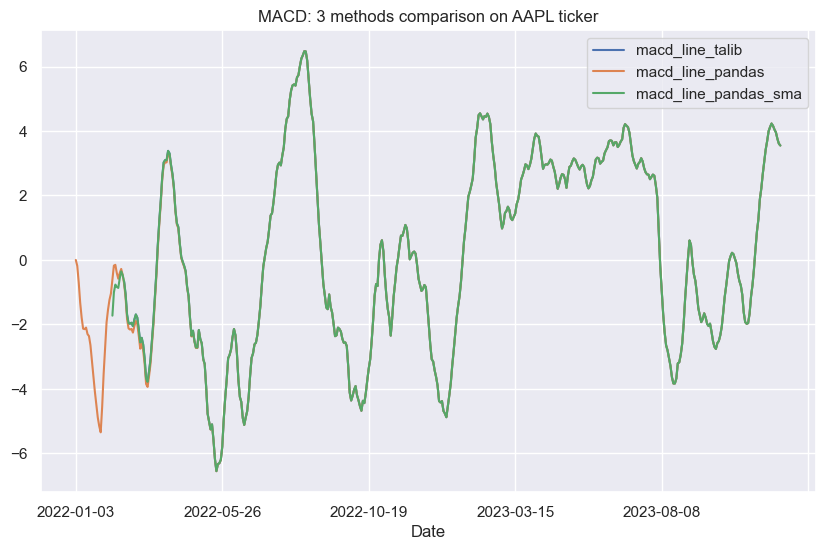

In [8]:
chosen_stock_prices[['macd_line_talib','macd_line_pandas','macd_line_pandas_sma']].plot(figsize=(10,6))
plt.title("MACD: 3 methods comparison on {} ticker".format(chosen_ticker))
plt.show()

We observe that the out-of-the-box pandas implementations slightly differes from the talib implementation while the initialization with simple moving average is more faithful.

### 3.3 Interpretations

In [9]:
def plot_technical_indicators(df, ticker='GOOG') :
    
    buy_signals = (df['macd_line_pandas_sma'] > df['signal_pandas_ema_sma']) & (df['macd_line_pandas_sma'].shift(1) <= df['signal_pandas_ema_sma'].shift(1))
    sell_signals = (df['macd_line_pandas_sma'] < df['signal_pandas_ema_sma']) & (df['macd_line_pandas_sma'].shift(1) >= df['signal_pandas_ema_sma'].shift(1))
    
    # Find centerline crossover points
    bullish_centerline_crossover = (df['macd_line_pandas_sma'] > 0) & (df['macd_line_pandas_sma'].shift(1) <= 0)
    bearish_centerline_crossover = (df['macd_line_pandas_sma'] < 0) & (df['macd_line_pandas_sma'].shift(1) >= 0)
    
    figsize=(12,15)
    fig, (ax0,ax1, ax2) = plt.subplots(nrows=3, sharex=False, subplot_kw=dict(frameon=True),figsize=figsize)
    
    ################### FAST EMA, SLOW EMA AND CLOSE PRICE
    df[['fast_ema','slow_ema']].plot(ax=ax0,style='--')
    close_price_line = df[['Adj Close']].plot(ax=ax0)
    
    ax0.set_title("Fast and Slow EMA plotted against Close prices on {} stock".format(ticker))
    ax0.set_ylabel("Close Prices ($)")
    
    
    ################### MACD indicators and buy and sell signals
    df['macd_line_pandas_sma'].plot(ax=ax1,label='macd',c='orange')
    df['signal_pandas_ema_sma'].plot(ax=ax1,style='--',label='macd signal line',c='blue')
    ax1.bar(df.index,df['macd_hist_sma'],label='macd histogram')
    ax1.axhline(y=0, color='black', linestyle='--')
    
    # Adding big circle points for buy and sell signals
    for index in df[buy_signals].index:
        ax1.scatter(index, df.at[index, 'macd_line_pandas_sma'], color='green', s=50, zorder=5)
    
    for index in df[sell_signals].index:
        ax1.scatter(index, df.at[index, 'macd_line_pandas_sma'], color='red', s=50, zorder=5)
    
    # Manually defining legend
    macd_line_legend = plt.Line2D([0], [0], color='orange', label='MACD line', markersize=10)
    macd_signal_legend = plt.Line2D([0], [0], color='blue', label='MACD Signal line', markersize=10)
    bar_legend = plt.Line2D([0], [0], marker='s', color='w', label='MACD Histogram', markersize=10)
    buy_legend = plt.Line2D([0], [0], marker='o', color='w', label='Buy Signal', markersize=10, markerfacecolor='green')
    sell_legend = plt.Line2D([0], [0], marker='o', color='w', label='Sell Signal', markersize=10, markerfacecolor='red')

    ax1.legend(handles=[macd_line_legend, macd_signal_legend, bar_legend ,buy_legend, sell_legend])
    
    ax1.set_title("MACD Indicators with Buy and Sell Signals on {} stock".format(ticker))
    
    ################### MACD indicators and bearish and bullish crossovers
    
    df['macd_line_pandas_sma'].plot(ax=ax2,label='macd',c='orange')
    df['signal_pandas_ema_sma'].plot(ax=ax2,style='--',label='macd signal line',c='blue')
    ax2.bar(df.index,df['macd_hist_sma'],label='macd histogram')
    ax2.axhline(y=0, color='black', linestyle='--')
    
    # Adding diagonal lines for centerline crossovers
    window = 5
    shift = 0
    for index in df[bullish_centerline_crossover].index:
        idx = df.index.get_loc(index)
        if idx > 0:
            prev_date = df.index[idx - window]
            curr_date = df.index[idx + window] if idx+window < df.shape[0] else df.index[df.shape[-1]]
            prev_value = df.at[prev_date, 'macd_line_pandas_sma'] + shift
            curr_value = df.at[curr_date, 'macd_line_pandas_sma'] + shift
            ax2.plot([prev_date, curr_date], [prev_value, curr_value], color='black', lw=2)

    for index in df[bearish_centerline_crossover].index:
        idx = df.index.get_loc(index)
        if idx > 0:
            prev_date = df.index[idx - window]
            curr_date = df.index[idx + window] if idx+window < df.shape[0] else df.index[df.shape[-1]]
            prev_value = df.at[prev_date, 'macd_line_pandas_sma'] + shift
            curr_value = df.at[curr_date, 'macd_line_pandas_sma'] + shift
            ax2.plot([prev_date, curr_date], [prev_value, curr_value], color='gray', lw=2)
    
    #Bullish and bearish
    bullish_centerline_legend = plt.Line2D([0], [0], lw=2, color='black', label='Bullish Centerline Crossover', markersize=10)
    bearish_centerline_legend = plt.Line2D([0], [0], lw=2, color='gray', label='Bearish Centerline Crossover', markersize=10)
    
    ax2.legend(handles=[macd_line_legend, macd_signal_legend, bar_legend ,bullish_centerline_legend, bearish_centerline_legend])
    
    
    ax2.set_title("MACD Indicators with Bullish and Bearish crossovers on {} stock".format(ticker))
    plt.show()

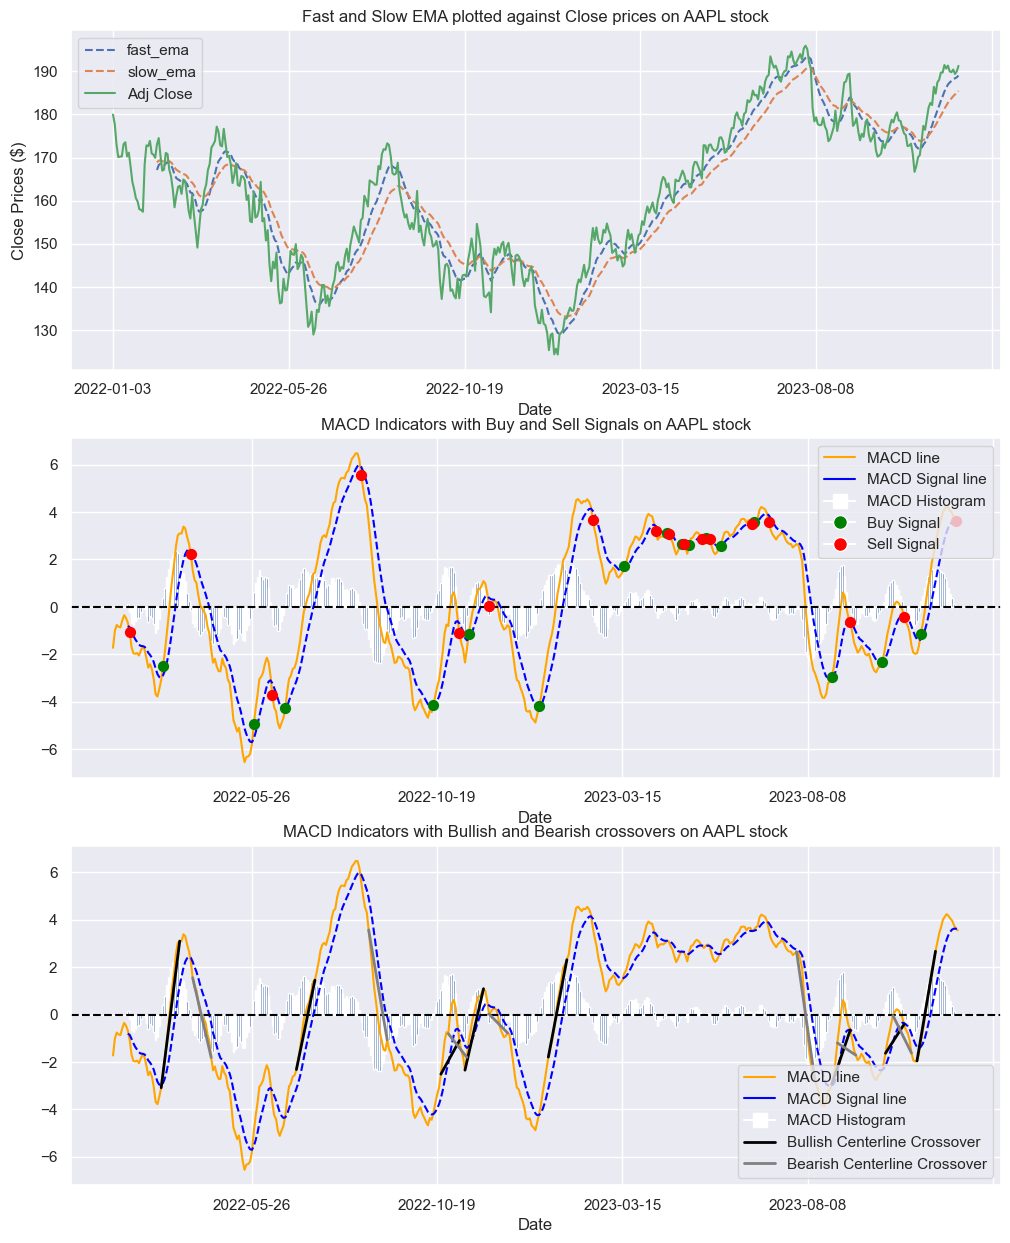

In [10]:
plot_technical_indicators(chosen_stock_prices, ticker=chosen_ticker)

**MACD, Fast and Slow EMA**

The MACD line is the difference between two moving averages (a slow one and a fast one). It helps spot when a trend is changing. 

By looking at how the MACD line compares to its signal line, it can help figuring out how strong the trend is and whether it's about to reverse.

**Signal Line Crossovers**:
- If the MACD line goes above the signal line, it's a sign you might want to buy. This is called a bullish crossover.
- If the MACD line drops below the signal line, it's a hint you might want to sell. This is known as a bearish crossover.
- These crossovers show that the price of the asset is starting to move faster, either up or down.
- However, sometimes these signals can be misleading, especially when the price of the asset is changing rapidly and unpredictably. (highly volatile)

**Centerline Crossovers**:
- When the MACD line crosses the zero line, it means the trend's direction is changing.
- If the MACD line moves above zero, it suggests the trend is becoming positive, or bullish.
- If the MACD line goes below zero, it suggests the trend is turning negative, or bearish.
- Crossing the zero line is another way to confirm that the trend direction is changing.

**Caveat** : It may be useful to use other indicators to back these signals, or wait some time to confirm momentum directions before taking any trading decision.

## 4. Simple Buy and Sell Trading strategies

Can we use MACD technical indicators to devise an effective trading strategy for an asset porfolio ?

**Transactions Costs**

For the sake of realism, we will consider a scenario where a low fixed transaction cost of $\$5$ is applied, in addition to a zero-commission scenario, which is becoming more and more likely in retail investing. 

### 4.1 Data Preparation

In [11]:
chosen_stock_prices.tail()

,Open,High,Low,Close,Adj Close,Volume,ticker,macd_line_talib,macd_signal_talib,macd_hist_talib,macd_line_pandas,macdsignal_pandas,macdhist_pandas,macd_line_pandas_sma,signal_pandas_ema_sma,macd_hist_sma,fast_ema,slow_ema
Date,,,,,,,,,,,,,,,,,,
2023-11-27,189.919998,190.669998,188.899994,189.789993,189.789993,40552600,AAPL,4.044855,3.494951,0.549904,4.044855,3.494951,0.549904,4.044855,3.494951,0.549904,187.762554,183.717699
2023-11-28,189.779999,191.080002,189.399994,190.399994,190.399994,38415400,AAPL,3.955630,3.587087,0.368543,3.955630,3.587087,0.368543,3.955630,3.587087,0.368543,188.168314,184.212684
2023-11-29,190.899994,192.089996,188.970001,189.369995,189.369995,43014200,AAPL,3.758481,3.621366,0.137115,3.758481,3.621366,0.137115,3.758481,3.621366,0.137115,188.353188,184.594707
2023-11-30,189.839996,190.320007,188.190002,189.949997,189.949997,48794400,AAPL,3.607456,3.618584,-0.011128,3.607456,3.618584,-0.011128,3.607456,3.618584,-0.011128,188.598851,184.991395
2023-12-01,190.330002,191.559998,189.229996,191.240005,191.240005,45679300,AAPL,3.550927,3.605053,-0.054125,3.550927,3.605053,-0.054125,3.550927,3.605053,-0.054125,189.005183,185.454255


In [12]:
def obtain_technical_indicators(df) :

    #Apply MACD
    df = macd_custom_pandas_implementation(df)

    # Find crossover points
    buy_signals = (df['macd_line_pandas_sma'] > df['signal_pandas_ema_sma']) & (df['macd_line_pandas_sma'].shift(1) <= df['signal_pandas_ema_sma'].shift(1))
    sell_signals = (df['macd_line_pandas_sma'] < df['signal_pandas_ema_sma']) & (df['macd_line_pandas_sma'].shift(1) >= df['signal_pandas_ema_sma'].shift(1))
    
    # Find centerline crossover points
    bullish_centerline_crossover = (df['macd_line_pandas_sma'] > 0) & (df['macd_line_pandas_sma'].shift(1) <= 0)
    bearish_centerline_crossover = (df['macd_line_pandas_sma'] < 0) & (df['macd_line_pandas_sma'].shift(1) >= 0)
    
    
    df['buy_signals'] = buy_signals.values
    df['sell_signals'] = sell_signals.values
    df['bullish_centerline_crossover'] = bullish_centerline_crossover.values
    df['bearish_centerline_crossover'] = bearish_centerline_crossover.values

    return df


stock_prices_with_technical_indicators = None

for ticker in tickers :
    if(stock_prices_with_technical_indicators is None) :
        stock_prices_with_technical_indicators = obtain_technical_indicators(stocks_prices.loc[stocks_prices['ticker'] == ticker])
    else :
        stock_prices_with_technical_indicators = pd.concat([stock_prices_with_technical_indicators, obtain_technical_indicators(stocks_prices.loc[stocks_prices['ticker'] == ticker])])


USEFUL_COLUMNS = [
    'ticker',
    'Open',
    'High',
    'Low',
    'Adj Close',
    'Volume',
    'macd_line_pandas_sma',
    'signal_pandas_ema_sma',
    'macd_hist_sma',
    'fast_ema',
    'slow_ema',
    'buy_signals',
    'sell_signals',
    'bullish_centerline_crossover',
    'bearish_centerline_crossover'
]

trading_dataset = stock_prices_with_technical_indicators[USEFUL_COLUMNS].copy()
trading_dataset = trading_dataset.rename(columns={
    'Adj Close' : 'Close',
    'macd_line_pandas_sma' : 'MACD_line',
    'signal_pandas_ema_sma' : 'MACD_signal',
    'macd_hist_sma' : 'MACD_hist',
    'fast_ema' : 'Short_EMA',
    'slow_ema' : 'Long_EMA',
    'buy_signals' : 'MACD_signal_upward_cross',
    'sell_signals' : 'MACD_signal_downward_cross',
})

trading_dataset.sort_index(inplace=True)

In [13]:
trading_dataset.tail()

,ticker,Open,High,Low,Close,Volume,MACD_line,MACD_signal,MACD_hist,Short_EMA,Long_EMA,MACD_signal_upward_cross,MACD_signal_downward_cross,bullish_centerline_crossover,bearish_centerline_crossover
Date,,,,,,,,,,,,,,,
2023-12-01,AAPL,190.330002,191.559998,189.229996,191.240005,45679300,3.550927,3.605053,-0.054125,189.005183,185.454255,False,False,False,False
2023-12-01,AMZN,146.000000,147.250000,145.550003,147.029999,39924600,3.395286,3.565222,-0.169936,145.377414,141.982128,False,False,False,False
2023-12-01,GOOG,133.320007,133.500000,132.151993,133.320007,24258400,0.676080,0.936365,-0.260284,135.986430,135.310350,False,True,False,False
2023-12-01,META,325.480011,326.859985,320.760010,324.820007,15264700,4.781940,6.295448,-1.513508,331.326772,326.544832,False,False,False,False
2023-12-01,MSFT,376.760010,378.160004,371.309998,374.510010,33020400,9.925999,10.745660,-0.819661,374.415964,364.489965,False,False,False,False


### 4.2 Simple Portfolio Trading Strategy

In [14]:
trading_dataset.head(10)

,ticker,Open,High,Low,Close,Volume,MACD_line,MACD_signal,MACD_hist,Short_EMA,Long_EMA,MACD_signal_upward_cross,MACD_signal_downward_cross,bullish_centerline_crossover,bearish_centerline_crossover
Date,,,,,,,,,,,,,,,
2022-01-03,GOOG,144.475494,145.550003,143.502502,145.074493,25214000,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2022-01-03,AMZN,167.550003,170.703506,166.160507,170.404495,63520000,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2022-01-03,MSFT,335.350006,338.000000,329.779999,328.727661,28865100,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2022-01-03,AAPL,177.830002,182.880005,177.710007,179.953888,104487900,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2022-01-03,META,338.299988,341.079987,337.190002,338.540009,14537900,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2022-01-04,GOOG,145.550507,146.610001,143.816147,144.416504,22928000,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2022-01-04,AMZN,170.438004,171.399994,166.349503,167.522003,70726000,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2022-01-04,MSFT,334.829987,335.200012,326.119995,323.090912,32674300,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2022-01-04,AAPL,182.630005,182.940002,179.119995,177.669998,99310400,NaN,NaN,NaN,NaN,NaN,False,False,False,False


In [15]:
def simple_macd_strategy(df, tickers, portfolio_initial_value = 100000, amount_spending_allocation = 10000, transaction_cost = 5) :

    # Initialize portfolio
    cash_balance = portfolio_initial_value
    holdings = {ticker: 0 for ticker in tickers}
    daily_portfolio_values = []
    allowed_amount_per_trade = amount_spending_allocation
    cumulative_transaction_costs = 0

    #Implement the strategy
    for idx in df.index.unique():
        current_holding_value = 0
        for ticker in tickers:
            # Check for buy/sell/hold signal.

            
            #EMA at time t is computed using data from t-1, t-2, ... so we are safe in using MACD signal at time t
            #buy_condition : if MACD crosses signal -> trend is changing upward -> we buy
            buy_condition = (df.loc[(df.index == idx) & (df.ticker == ticker), 'MACD_signal_upward_cross'].values[0] == True) or (df.loc[(df.index == idx) & (df.ticker == ticker), 'bullish_centerline_crossover'].values[0] == True)
            sell_condition = (df.loc[(df.index == idx) & (df.ticker == ticker), 'MACD_signal_downward_cross'].values[0] == True) or (df.loc[(df.index == idx) & (df.ticker == ticker), 'bearish_centerline_crossover'].values[0] == True)

            
            #We assume we make the trade orders before market opens
            #and that we will be buying at market value
            asset_price = df.loc[(df.index == idx) & (df.ticker == ticker), 'Open'].values[0]
            ticker_holdings_value = holdings[ticker] * asset_price
            
            if buy_condition:
                # Execute buy if sufficient cash is available
                if(cash_balance > 0) :
                    maximum_shares_to_buy = min(allowed_amount_per_trade, cash_balance) //  asset_price
                    spent_amount = maximum_shares_to_buy * asset_price + transaction_cost
                    
                    # Check if we have enough to be able to buy when we consider transaction costs
                    if(spent_amount <= cash_balance) :
                        cash_balance -= spent_amount
                        holdings[ticker] += maximum_shares_to_buy
                        cumulative_transaction_costs += transaction_cost
            
            elif sell_condition:
                # Execute sell if holdings are available

                if(holdings[ticker] > 0) : #If we have holdings available to sell
                    maximum_shares_to_sell = min(allowed_amount_per_trade, ticker_holdings_value) //  asset_price
                    earned_amount = maximum_shares_to_sell * asset_price + transaction_cost
                
                    # Check if we have enough to be able to sell when we consider transaction costs
                    if(transaction_cost <= cash_balance) :
                        # Update cash_balance and holdings
                        cash_balance += earned_amount
                        holdings[ticker] -= maximum_shares_to_sell
                        cumulative_transaction_costs += transaction_cost
            else : 
                #if neither buy nor sell, we hold
                pass

            #Update holdings value at the close of the market
            asset_price_at_close = df.loc[(df.index == idx) & (df.ticker == ticker), 'Close'].values[0]
            ticker_holdings_value = holdings[ticker] * asset_price_at_close
            current_holding_value += ticker_holdings_value


        #Update portfolio value for the day
        daily_portfolio_value = cash_balance + current_holding_value
        daily_portfolio_values.append([idx, daily_portfolio_value, cash_balance, current_holding_value, cumulative_transaction_costs]+[holdings[t] for t in tickers])

    return daily_portfolio_values

In [16]:
portfolio_values = simple_macd_strategy(trading_dataset, tickers, transaction_cost = 5)
portfolio_over_time = pd.DataFrame(portfolio_values, columns=['date', 'portfolio_value', 'cash_balance', 'holdings_value', 'cumulative_transaction_costs']+['{}_holdings'.format(t) for t in tickers])
portfolio_over_time

,date,portfolio_value,cash_balance,holdings_value,cumulative_transaction_costs,GOOG_holdings,AMZN_holdings,META_holdings,AAPL_holdings,MSFT_holdings
0,2022-01-03,100000.000000,100000.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0
1,2022-01-04,100000.000000,100000.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0
2,2022-01-05,100000.000000,100000.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0
3,2022-01-06,100000.000000,100000.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0
4,2022-01-07,100000.000000,100000.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
477,2023-11-27,163997.766937,3.476958,163994.289979,725,215.0,142.0,171.0,140.0,78.0
478,2023-11-28,165158.924127,3.476958,165155.447169,725,215.0,142.0,171.0,140.0,78.0
479,2023-11-29,162975.218482,3.476958,162971.741524,725,215.0,142.0,171.0,140.0,78.0
480,2023-11-30,161631.684826,3.476958,161628.207868,725,215.0,142.0,171.0,140.0,78.0


## 5. BackTesting

### 5.0 BenchMark Trading Strategies

Many strategies can be used to reflect the market portfolio evolutions.

For simplicity, we will be implementing a dollar-cost averaging (DCA) strategy with the SPDR S&P 500 ETF Trust (SPY).

Dollar-cost averaging involves regularly buying a fixed dollar amount of a particular investment, regardless of its price, on a regular schedule. Over time, this can help reduce the impact of volatility on the overall purchase. 

The costs average out since the same amount is invested in each period.

In this particular case, since we are given a initial cash balance of $\$100000$ and we choose to use DCA over a period of almost 2 years, we will adjust the **allowed_amount_per_trade** to $\$500$.

In [17]:
def market_benchmark_strategy(df, market_tickers = ['SPY'] ,portfolio_initial_value = 100000, strategy = 'DCA', ticker = 'SPY', amount_spending_allocation = 500, transaction_cost = 5) :

    if(strategy == 'DCA') :
        cash_balance = portfolio_initial_value
        holdings = {ticker : 0} #Number of shares at the start of the trading period
        daily_portfolio_values = []
        allowed_amount_per_trade = amount_spending_allocation
        cumulative_transaction_costs = 0

        for idx in df.index.unique():
            current_holding_value = 0

            #We assume we make the trade orders before market opens
            #and that we will be buying at market value
            asset_price = df.loc[(df.index == idx), 'Open'].values[0]

            if(cash_balance > 0) :
                maximum_shares_to_buy = min(allowed_amount_per_trade, cash_balance) //  asset_price
                spent_amount = maximum_shares_to_buy * asset_price

                # Check if we have enough to be able to buy when we consider transaction costs
                if(spent_amount <= cash_balance) :
                    # Update cash_balance and holdings
                    cash_balance -= spent_amount
                    holdings[ticker] += maximum_shares_to_buy
                    cumulative_transaction_costs += transaction_cost
            else :
                pass

            asset_price_at_close = df.loc[(df.index == idx), 'Close'].values[0]
            ticker_holdings_value = holdings[ticker] * asset_price_at_close
            current_holding_value += ticker_holdings_value

            ##Update holdings value at the close of the market
            daily_portfolio_value = cash_balance + current_holding_value
            daily_portfolio_values.append([idx, daily_portfolio_value, cash_balance, current_holding_value, cumulative_transaction_costs]+[holdings[t] for t in market_tickers])

    return daily_portfolio_values

In [18]:
market_tickers = ['SPY']
market_portfolio_values =  market_benchmark_strategy(df = market_prices, amount_spending_allocation=500)
market_portfolio_over_time = pd.DataFrame(market_portfolio_values, columns=['date', 'portfolio_value', 'cash_balance', 'holdings_value', 'cumulative_transaction_costs']+['{}_holdings'.format(t) for t in market_tickers])
market_portfolio_over_time


,date,portfolio_value,cash_balance,holdings_value,cumulative_transaction_costs,SPY_holdings
0,2022-01-03,100001.410003,99523.700012,477.709991,5,1.0
1,2022-01-04,99999.579987,99044.480011,955.099976,10,2.0
2,2022-01-05,99972.460022,98567.320007,1405.140015,15,3.0
3,2022-01-06,99971.190000,98099.429992,1871.760008,20,4.0
4,2022-01-07,99961.929960,97631.479980,2330.449980,25,5.0
...,...,...,...,...,...,...
477,2023-11-27,110905.042875,11.920191,110893.122684,2390,244.0
478,2023-11-28,111014.838483,11.920191,111002.918292,2395,244.0
479,2023-11-29,110936.756531,11.920191,110924.836340,2400,244.0
480,2023-11-30,111373.518727,11.920191,111361.598536,2405,244.0


### 5.1 Defining Performance metrics

Now let's define some **performance metrics** to have a proper understanding how our portfolio performed during the entire period.

Those will include **Total Returns, Annualized Returns, Maximum Drawdown, Sharpe Ratio, Sortino Ratio, Beta to the Market and Alpha.**

#### 5.1.1 Total Returns

Total returns measure the overall profitability of the strategy.

Example :
An investor buys 100 shares of Stock A at $\$20$ per share for an initial value of $\$2,000$. Stock A pays a 5% dividend the investor reinvests, buying five additional shares. After one year, the share price rises to $\$22$.

To calculate the investment's total return, the investor divides the total investment gains (105 shares x $\$22$ per share = $\$2,310$ current value - $\$2,000$ initial value = $\$310$ total gains) by the initial value of the investment ($\$2,000$) and multiplies by 100 to convert the answer to a percentage ($\$310$ / $\$2,000$ x 100 = 15.5%). The investor's total return is 15.5%.

Reference : https://www.investopedia.com/terms/t/totalreturn.asp

In [19]:
def calculate_total_returns(portfolio_values : pd.Series) -> float:
    initial_portfolio_value = portfolio_values.iloc[0]
    final_portfolio_value = portfolio_values.iloc[-1]
    return 100 * (final_portfolio_value - initial_portfolio_value) / initial_portfolio_value

#### 5.1.2 Annualized Returns

Annualized returns show the average yearly return, assuming the strategy can be scaled over multiple years.

Consider an investor that purchases a stock on Jan. 1, 2000, for $\$20$. The investor then sells it on Jan. 1, 2005, for $\$35$ – a $\$15$ profit. The investor also receives a total of $\$2$ in dividends over the five-year holding period. In this example, the investor's total return over five years is $\$17$, or (17/20) 85% of the initial investment

Reference : https://www.investopedia.com/terms/a/annual-return.asp

In [20]:
def calculate_annualized_returns(portfolio_values : pd.Series, start_date : dt.datetime, end_date : dt.datetime) -> float:
    years = (end_date - start_date).days / 365.25

    initial_portfolio_value = portfolio_values.iloc[0]
    final_portfolio_value = portfolio_values.iloc[-1]
    
    return ((final_portfolio_value/initial_portfolio_value) ** (1/years)) - 1


#### 5.1.3 Maximum drawdown

Maximum drawdown is a specific measure of drawdown that looks for the greatest movement from a high point to a low point, before a new peak is achieved. However, it's important to note that it only measures the size of the largest loss, without taking into consideration the frequency of large losses. Because it measures only the largest drawdown, MDD does not indicate how long it took an investor to recover from the loss, or if the investment even recovered at all.

Maximum drawdown (MDD) is an indicator used to assess the relative riskiness of one stock screening strategy versus another, as it focuses on capital preservation, which is a key concern for most investors. For example, two screening strategies can have the same average outperformance, tracking error, and volatility, but their maximum drawdowns compared to the benchmark can be very different.

A low maximum drawdown is preferred as this indicates that losses from investment were small. If an investment never lost a penny, the maximum drawdown would be zero. The worst possible maximum drawdown would be -100%, meaning the investment is completely worthless.

Reference : https://www.investopedia.com/terms/m/maximum-drawdown-mdd.asp

**Example** : 

Let's say we have the following portfolio values over five days [100, 120, 110, 105, 115].

The rolling maximum values are [100, 120, 120, 120, 120].

The (rounded) daily drawdowns are [0, 0, -0.0833, -0.125, -0.0417].

The maximum drawdown is -0.125 or 12.5%, which is the largest drop from a peak during this period. This is also the minimum value of the daily drawdonws.


In [21]:
def calculate_max_drawdown(portfolio_values : pd.Series) -> float:

    #computes the rolling maximum of the portfolio values. 
    #For each point in time, compute the highest value of the portfolio reached so far.
    rolling_max = np.maximum.accumulate(portfolio_values)

    #calculates the drawdown, which is the percentage decline at each point from the rolling maximum.
    daily_drawdown = (portfolio_values - rolling_max)/rolling_max

    #finds the minimum of these daily drawdown values, which represents the maximum drawdown.
    max_drawdown = np.min(daily_drawdown)
    return max_drawdown

#### 5.1.4 Sharpe ratio

The Sharpe ratio divides a portfolio's excess returns by a measure of its volatility to assess risk-adjusted performance
excess returns are those above an industry benchmark or the risk-free rate of return.

The greater a portfolio's Sharpe ratio, the better its risk-adjusted performance. A negative Sharpe ratio means the risk-free or benchmark rate is greater than the portfolio’s historical or projected return, or else the portfolio's return is expected to be negative.

It can help explain whether a portfolio's excess returns are attributable to smart investment decisions or simply luck and risk.

$SharpeRatio = \frac{PortfolioReturn - RiskFreeRate}{StandardDeviationOfPortfolioExcessReturn}$

The risk-free rate is usually the return on a very safe investment, such as U.S. Treasury bills (T-bills) or government bonds. These are considered virtually risk-free, especially for short-term investments.

For the sake of simplicity and learning here, we will be using a **static risk free rate of 5%** based on the current values of T-bills (5.43%) found here : https://ycharts.com/indicators/3_month_treasury_rate#:~:text=3%20Month%20Treasury%20Rate%20is,a%20maturity%20of%203%20months.

**Note :** In a more detailed analysis, or in real-world applications, using historical data for the risk-free rate would provide more precise results, as it evolves over time.

Reference : https://www.investopedia.com/terms/s/sharperatio.asp

In [22]:
def calculate_sharpe_ratio(portfolio_values : pd.Series, risk_free_rate : float =0.05, ANNUAL_TRADING_DAYS : int = 252) -> float:
    
    #Compute changes in portfolio values from one period to another
    portfolio_changes = np.diff(portfolio_values)
    #Portfolio value at the beginning of each period
    beginning_portfolio_values = portfolio_values[:-1]
    #compute daily returns
    daily_returns = portfolio_changes / beginning_portfolio_values
    #converts the annual risk-free rate to a daily rate based on a number of trading days
    daily_risk_free_rate = risk_free_rate/ANNUAL_TRADING_DAYS
    #calculates the excess returns by subtracting the daily risk-free rate from the daily returns. 
    excess_returns = daily_returns - daily_risk_free_rate

    #Scales the sharpe ratio to a yearly measure based on a number of trading days
    scaling_factor = np.sqrt(ANNUAL_TRADING_DAYS)
    #calculate the average excess returns of the portfolio
    average_excess_returns = np.mean(excess_returns)
    #Computes the standard deviation of the excess returns, representing the risk or volatility of the portfolio.
    portfolio_volatility = np.std(excess_returns)

    #Sharpe Ratio is then calculated as the average excess return per unit of risk (volatility), scaled to an annual basis.
    sharpe_ratio = scaling_factor  * average_excess_returns / portfolio_volatility
    return sharpe_ratio

### 5.1.5 Sortino ratio

Sortino ratio is similar to the Sharpe ratio but only considers downside volatility.

The Sortino ratio is a useful way for investors, analysts, and portfolio managers to evaluate an investment's return for a given level of bad risk. Since this ratio uses only the downside deviation as its risk measure, it addresses the problem of using total risk, or standard deviation, which is important because upside volatility is beneficial to investors and isn't a factor most investors worry about.

Just like the Sharpe ratio, a higher Sortino ratio result is better. When looking at two similar investments, a rational investor would prefer the one with the higher Sortino ratio because it means that the investment is earning more return per unit of the bad risk that it takes on.


$SortinoRatio = \frac{PortfolioReturn - RiskFreeRate}{StandardDeviationOfPortfolioDownsideReturn}$

Reference : https://www.investopedia.com/terms/s/sortinoratio.asp


In [23]:
def calculate_sortino_ratio(portfolio_values : pd.Series, risk_free_rate : float = 0.05, ANNUAL_TRADING_DAYS : int = 252) -> float:
    
    #compute daily returns
    daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    #Extract downside returns. If a return is less than the daily risk-free rate, it's considered a downside return. 
    #Otherwise, it's set to 0, as it's not part of the downside risk.
    downside_returns = np.where(daily_returns < risk_free_rate/ANNUAL_TRADING_DAYS, daily_returns, 0)
    
    #calculates the expected return of the portfolio,
    expected_return = np.mean(daily_returns) - risk_free_rate/ANNUAL_TRADING_DAYS

    #Computes the standard deviation of the downside returns representing the risk associated with these downside returns.
    downside_volatility = np.std(downside_returns)
    
    sortino_ratio = np.sqrt(ANNUAL_TRADING_DAYS) * expected_return / downside_volatility
    return sortino_ratio

#### 5.1.6 Beta to the Market

Beta (β), primarily used in the capital asset pricing model (CAPM), is a measure of the volatility or systematic risk of a security or portfolio compared to the market as a whole. Stocks with betas higher than 1.0 can be interpreted as more volatile than the S&P 500.

Beta data about an individual stock can only provide an investor with an approximation of how much risk the stock will add to a (presumably) diversified portfolio.


$ BetaCoefficient (\beta) = \frac{Covariance(R_e, R_m)}{Variance(R_m)}$

where 
- $R_e$ : return on an individual stock
- $R_m$ : return on the overall market
- $Covariance(R_e, R_m)$ : how changes in a stock's returns are related to changes in the market's returns
- $Variance(R_m)$ : how far the market's data points spread out from their average value

Reference : https://www.investopedia.com/terms/b/beta.asp


In [24]:
def calculate_beta(portfolio_values : pd.Series, market_values : pd.Series) -> float:
    
    #compute portfolio daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]

    #compute market daily returns (considered index, e.g S&P 500)
    market_returns = np.diff(market_values) / market_values[:-1]
    
    covariance = np.cov(portfolio_returns, market_returns)[0][1]
    market_variance = np.var(market_returns)
    
    beta = covariance / market_variance
    return beta

#### 5.1.7 Alpha - active return on investment


Alpha $(\alpha)$ is a term used in investing to describe an investment strategy's ability to beat the market, or its **"edge."** Alpha is thus also often referred to as “excess return” or the “abnormal rate of return” in relation to a benchmark, when adjusted for risk. Alpha is often used in conjunction with beta $(\beta)$, which measures the broad market's overall volatility or risk, known as systematic market risk.

Alpha is used in finance as a measure of performance, indicating when a strategy, trader, or portfolio manager has managed to beat the market return or other benchmark over some period. Alpha, often considered the **active return on an investment**, gauges the performance of an investment against a market index or benchmark that is considered to represent the market’s movement as a whole.

The excess return of an investment relative to the return of a benchmark index is the investment’s alpha. Alpha may be positive or negative and is the result of active investing. **Beta, on the other hand, can be earned through passive index investing.**


**Considering Fees**
Suppose that Jim, a financial advisor, charges 1% of a portfolio’s value for his services and that during a 12-month period, Jim managed to produce an alpha of 0.75 for the portfolio of one of his clients, Frank.

While Jim has indeed helped the performance of Frank’s portfolio, **the fee that Jim charges is in excess of the alpha he has generated**, so Frank’s portfolio has experienced a **net loss**. For investors, the example highlights the importance of considering fees in conjunction with performance returns and alpha.

Based on CAPM (Capital Asset Pricing Model), we have the following formula :

$$ExpectedReturn = riskFreePremium + Beta (expectedMarketReturn - riskFreePremium)$$

References 
- https://www.investopedia.com/terms/a/alpha.asp
- https://www.investopedia.com/terms/e/expectedreturn.asp

In [25]:
def calculate_alpha(portfolio_values : pd.Series, market_values : pd.Series, risk_free_rate : float = 0.05) -> float:

    #calculates the total return of the portfolio over the entire period.
    # It computes  the gain (in percentage) between the initial portfolio value and the ending portfolio value over the entire period.
    portfolio_return = (portfolio_values.iloc[-1] - portfolio_values.iloc[0]) / portfolio_values.iloc[0]
    
    #We do the same for the market index
    market_return = (market_values.iloc[-1] - market_values.iloc[0]) / market_values.iloc[0]

    #Use the previously defined function beta
    beta = calculate_beta(portfolio_values, market_values)

    #Calculates the market expected return of the portfolio based on the Capital Asset Pricing Model (CAPM). 
    expected_return = risk_free_rate + beta * (market_return - risk_free_rate)

    #Alpha is calculated as the difference between the actual total return of the portfolio (portfolio_return)
    #and the expected return based on its risk profile (expected_return)
    alpha = portfolio_return - expected_return
    return alpha

#### 5.1.8 Assessing our portfolio effectiveness


Let's use the defined metrics above to assess the effectiveness of our simple buy-sell trading strategy based on MACD.

In [26]:

def assess_portfolio_performance(PORTFOLIO : str, portfolio_values : pd.Series, 
                                 market_values : pd.Series, start_date : dt.datetime, 
                                 end_date : dt.datetime, TRANSACTIONS_FEES : float ) -> dict :

    #Total returns
    PORTFOLIO_TOTAL_RETURNS = calculate_total_returns(portfolio_values = portfolio_values)
    
    #Annualized returns
    ANNUALIZED_RETURNS = calculate_annualized_returns(portfolio_values = portfolio_values, start_date = start_date, end_date  = end_date)
    
    #Maximum drawdown
    MAX_DRAWDOWN = calculate_max_drawdown(portfolio_values = portfolio_values)
    
    #Sharpe ratio
    SHARPE_RATIO = calculate_sharpe_ratio(portfolio_values = portfolio_values)
    
    #Sortino ratio
    SORTINO_RATIO = calculate_sortino_ratio(portfolio_values = portfolio_values)
    
    #Beta to the market
    BETA = calculate_beta(portfolio_values = portfolio_values, market_values = market_values)
    
    #Alpha
    ALPHA = calculate_alpha(portfolio_values = portfolio_values, market_values = market_values)

    #Add cumulative amount spent on transactions costs

    return {
        'PORTFOLIO' : PORTFOLIO,
        'PORTFOLIO_TOTAL_RETURNS' : round(PORTFOLIO_TOTAL_RETURNS, 3),
        'ANNUALIZED_RETURNS' : round(ANNUALIZED_RETURNS, 3),
        'MAX_DRAWDOWN' : round(MAX_DRAWDOWN, 3),
        'SHARPE_RATIO' : round(SHARPE_RATIO, 3),
        'SORTINO_RATIO' : round(SORTINO_RATIO, 3),
        'BETA' : round(BETA, 3),
        'ALPHA' : round(ALPHA, 3),
        'TRANSACTIONS_FEES' : TRANSACTIONS_FEES,
    }

In [27]:
all_portfolio_performances = []


MACD_portfolio_performances = assess_portfolio_performance(PORTFOLIO = 'MACD Buy & Sell', 
                                                           portfolio_values = portfolio_over_time.portfolio_value,  
                                                           market_values = market_portfolio_over_time.portfolio_value, 
                                                           start_date = datetime_start, end_date = datetime_end,
                                                           TRANSACTIONS_FEES = portfolio_over_time['cumulative_transaction_costs'].iloc[-1])
all_portfolio_performances.append(MACD_portfolio_performances)

SP500_DCA_performances = assess_portfolio_performance(PORTFOLIO = 'SP500 DCA', 
                                                      portfolio_values = market_portfolio_over_time.portfolio_value,  
                                                      market_values = market_portfolio_over_time.portfolio_value, 
                                                      start_date = datetime_start, 
                                                      end_date = datetime_end,
                                                      TRANSACTIONS_FEES = market_portfolio_over_time['cumulative_transaction_costs'].iloc[-1])

all_portfolio_performances.append(SP500_DCA_performances)

all_portfolio_performances = pd.DataFrame.from_dict(all_portfolio_performances)
all_portfolio_performances

,PORTFOLIO,PORTFOLIO_TOTAL_RETURNS,ANNUALIZED_RETURNS,MAX_DRAWDOWN,SHARPE_RATIO,SORTINO_RATIO,BETA,ALPHA,TRANSACTIONS_FEES
0,MACD Buy & Sell,61.075,0.282,-0.166,1.054,1.980,1.020,0.489,725
1,SP500 DCA,12.031,0.061,-0.126,0.138,0.241,1.002,-0.000,2410


In [28]:
tickers

['GOOG', 'AMZN', 'META', 'AAPL', 'MSFT']

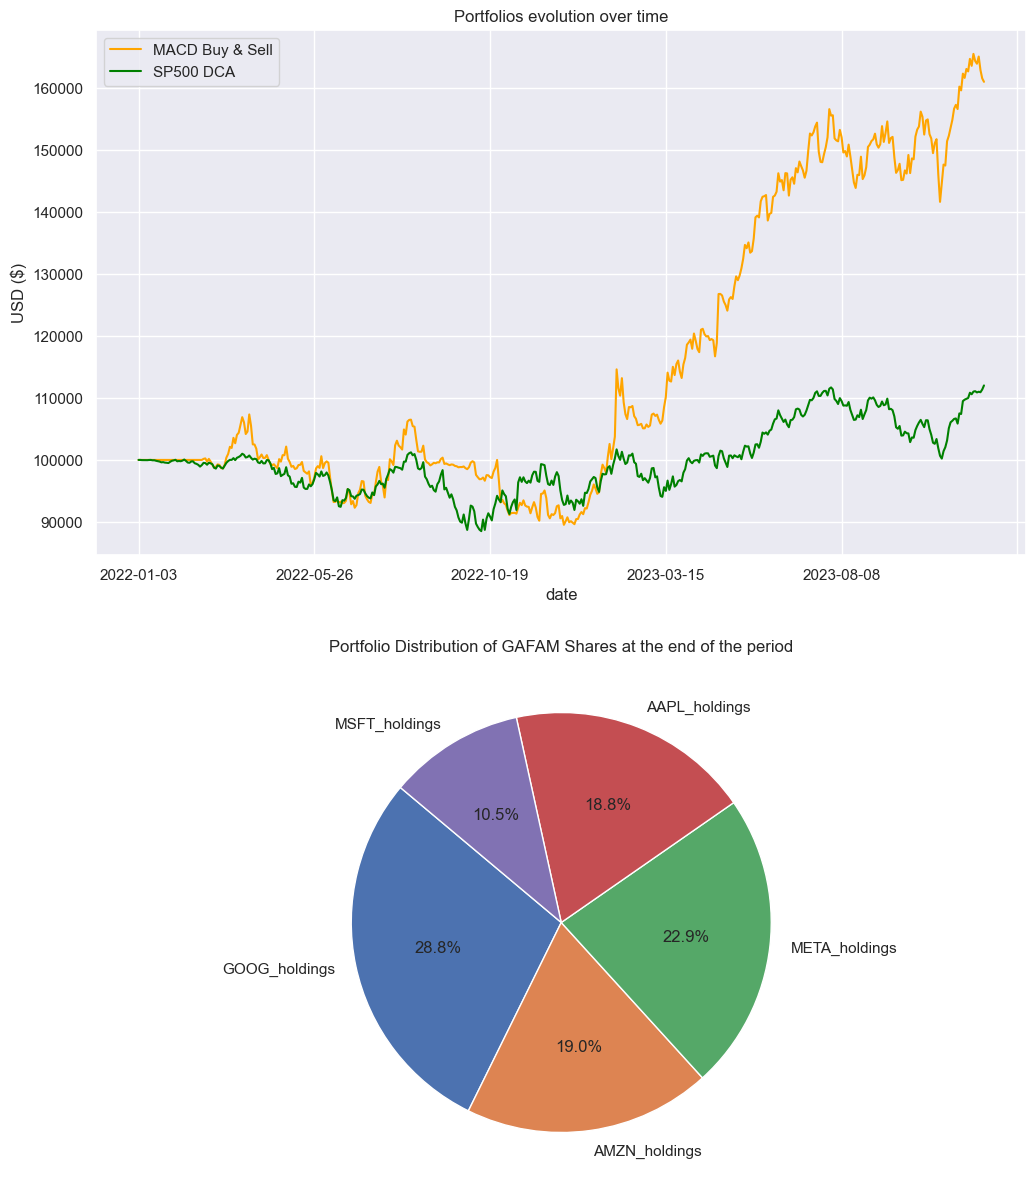

In [29]:
def plot_portfolio_evolutions() :
    figsize=(12,15)
    fig, (ax0,ax1) = plt.subplots(nrows=2, sharex=False, subplot_kw=dict(frameon=True),figsize=figsize)

    portfolio_over_time_with_date_index = portfolio_over_time.copy()
    portfolio_over_time_with_date_index.set_index('date', inplace=True)

    market_portfolio_over_time_with_date_index = market_portfolio_over_time.copy()
    market_portfolio_over_time_with_date_index.set_index('date', inplace=True)
    
    ############################################ Portfolio Evolutions over time
    portfolio_over_time_with_date_index['portfolio_value'].plot(ax=ax0,c='orange')
    market_portfolio_over_time_with_date_index['portfolio_value'].plot(ax=ax0,c='green')
    
    # Manually defining legend
    macd_portfolio_line = plt.Line2D([0], [0], color='orange', label='MACD Buy & Sell', markersize=10)
    sp500_portfolio_line = plt.Line2D([0], [0], color='green', label='SP500 DCA', markersize=10)

    ax0.legend(handles=[macd_portfolio_line, sp500_portfolio_line])
    
    ax0.set_title("Portfolios evolution over time")
    ax0.set_ylabel('USD ($)')

    ############################################ MACD portfolio allocation at the end of the period
    
    last_row = portfolio_over_time_with_date_index[['{}_holdings'.format(t) for t in tickers]].iloc[-1]

    # Data for Pie Chart
    labels = last_row.index
    sizes = last_row.values

    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

    ax1.set_title('Portfolio Distribution of GAFAM Shares at the end of the period')

    

plot_portfolio_evolutions()

## 6. Conclusion


### 6.1 Analysis Summary

Based on observed results, the MACD Buy & Sell strategy has outperformed the SP500 DCA strategy across most metrics, especially in terms of total and annualized returns. 

It suggests that active trading, in this case, has added significant value. However, the higher maximum drawdown for MACD Buy & Sell also indicates **higher risk**, which is something worth considering.

The passive SP500 DCA strategy exhibits **lower risk and volatility** as indicated by its max drawdown and beta close to 1 but has provided **lower returns**. The transaction fees for SP500 DCA are significantly higher due to the daily investment approach, which emphasizes the **impact fees can have on investment strategies**.

### 6.2 Discussion


- **Market Conditions**
The period over which we conducted the backtest may have been particularly favorable for the types of stocks in the MACD strategy and less favorable for the market as a whole. Thus, these performance metrics might look different under varying market conditions.

- **Strategy Robustness**
The MACD strategy's success rely on specific parameters and market behavior that may not be replicable in the future. It is widely accepted that strategies that work well in one period may not necessarily work well in others, especially in different market phases or conditions.

- **Risk Consideration**
A higher total return often comes with higher risk. The MACD strategy's higher max drawdown suggests that while it may offer higher returns, it also exposes to greater potential losses which is quite important for risk management.


- **Transaction Costs**
The backtest included transaction fees (highly simplified version), while others costs should have been considered, such as slippage (https://www.investopedia.com/terms/s/slippage.asp), taxes, and the impact of bid-ask spreads. For example an ETF held long-term could benefit from lower tax rate (long term capital gain), while frequent trading might result in short-term gains, taxed at a higher rate.


- **Benchmark Appropriateness**
The SP500 DCA strategy serves as a passive benchmark, but we may want to make sure it aligns with the risk profile of the MACD strategy. Since our MACD strategy is taking on significantly more risk, it might be worth comparing it to a more aggressive well knowns benchmarks.


- **Frequency of Trades**
We chose a daily frequency approach regarding Dollar Cost averaging while a less frequent investment schedule (ex : monthly) might have yielded better net returns.

- **Position adjusting and stop loss strategies**
We chose to use a fixed allowed amount for each trade, while we may have used a position adjusting amount based on market conditions at each trade.
Furthermore, we did not incorporate any stop loss or buy conditions based varying prices in our strategies.

- **Performance Metrics**
The Sharpe and Sortino ratios provide insight into risk-adjusted returns, but they are based on historical data. Forward-looking risk assessments may provide different insights.
Beta gives a sense of relative market risk, but it doesn't account for specific stock or sector risks inherent in a concentrated portfolio like the GAFAM stocks.
Alpha indicates performance above the market after adjusting for risk, but it is a backward-looking measure and doesn't guarantee future outperformance.

- **Survivorship Bias**
We selected these stocks based on their current status (big tech giants), so we might be introducing survivorship bias, potentially inflating past performance.

- **Dividends and Corporate Actions**
The backtest should account for dividends, stock splits, and other corporate actions to accurately reflect the total return of the investment, but for the sake of simplicity we decided to discard them.